In [1]:
import warnings
warnings.filterwarnings('ignore')
import scipy
import numpy as np 
import seaborn as sns
import pandas as pd 
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier  # for stacking model ensemble
from sklearn.preprocessing import LabelEncoder  # if you plan to use label encoding
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, ElasticNetCV
from sklearn.metrics import f1_score, roc_auc_score, brier_score_loss
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kstest, ttest_ind, ks_2samp, mannwhitneyu, mode
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier

2025-04-10 17:21:41.860790: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 17:21:41.875464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744320101.891150 2983055 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744320101.895983 2983055 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744320101.908492 2983055 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
SEED = 42
REPEATS = 5
FOLDS = 5

train_q = pd.read_excel("/projectnb/msspbc/vajinder/WiDS/Data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_c = pd.read_excel("/projectnb/msspbc/vajinder/WiDS/Data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
test_q = pd.read_excel("/projectnb/msspbc/vajinder/WiDS/Data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_c = pd.read_excel("/projectnb/msspbc/vajinder/WiDS/Data/TEST/TEST_CATEGORICAL.xlsx")

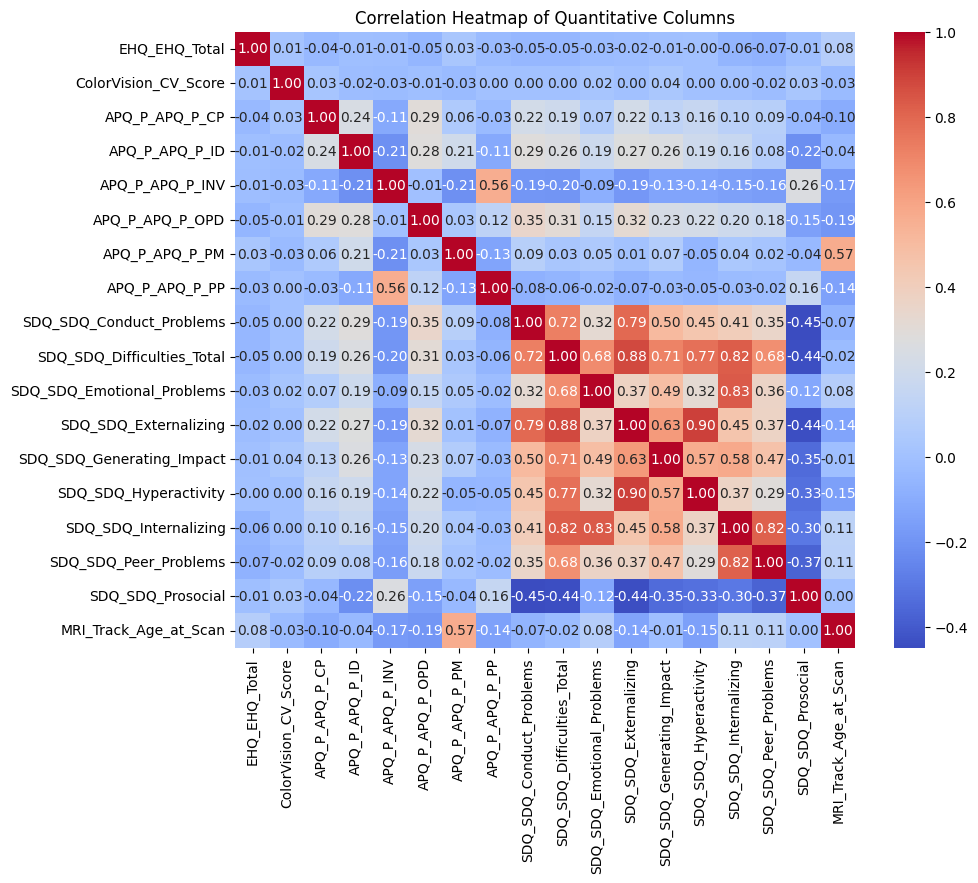

In [3]:
quantitative_columns = train_q.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = quantitative_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Heatmap of Quantitative Columns")
plt.show()

In [4]:
train_combined = pd.merge(train_q, train_c, on="participant_id", how="left").set_index("participant_id")
test_combined = pd.merge(test_q, test_c, on="participant_id", how="left").set_index("participant_id")

labels = pd.read_excel("/projectnb/msspbc/vajinder/WiDS/Data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")
train_combined = train_combined.sort_index()
labels = labels.sort_index()

assert all(train_combined.index == labels.index), "Label IDs don't match train IDs"

In [41]:
train_c['Basic_Demos_Enroll_Year'] = train_c['Basic_Demos_Enroll_Year'].astype('category')
train_c['Basic_Demos_Study_Site'] = train_c['Basic_Demos_Study_Site'].astype('category')
train_c['PreInt_Demos_Fam_Child_Ethnicity'] = train_c['PreInt_Demos_Fam_Child_Ethnicity'].astype('category')
train_c['PreInt_Demos_Fam_Child_Race'] = train_c['PreInt_Demos_Fam_Child_Race'].astype('category')
train_c['MRI_Track_Scan_Location'] = train_c['MRI_Track_Scan_Location'].astype('category')
train_c['Barratt_Barratt_P1_Edu'] = train_c['Barratt_Barratt_P1_Edu'].astype('category')
train_c['Barratt_Barratt_P1_Occ'] = train_c['Barratt_Barratt_P1_Occ'].astype('category')
train_c['Barratt_Barratt_P2_Edu'] = train_c['Barratt_Barratt_P2_Edu'].astype('category')
train_c['Barratt_Barratt_P2_Occ'] = train_c['Barratt_Barratt_P2_Occ'].astype('category')
labels['ADHD_Outcome'] = labels['ADHD_Outcome'].astype('category')
labels['Sex_F'] = labels['Sex_F'].astype('category')
print(train_c.dtypes)
print(labels.dtypes)

participant_id                        object
Basic_Demos_Enroll_Year             category
Basic_Demos_Study_Site              category
PreInt_Demos_Fam_Child_Ethnicity    category
PreInt_Demos_Fam_Child_Race         category
MRI_Track_Scan_Location             category
Barratt_Barratt_P1_Edu              category
Barratt_Barratt_P1_Occ              category
Barratt_Barratt_P2_Edu              category
Barratt_Barratt_P2_Occ              category
dtype: object
ADHD_Outcome    category
Sex_F           category
dtype: object


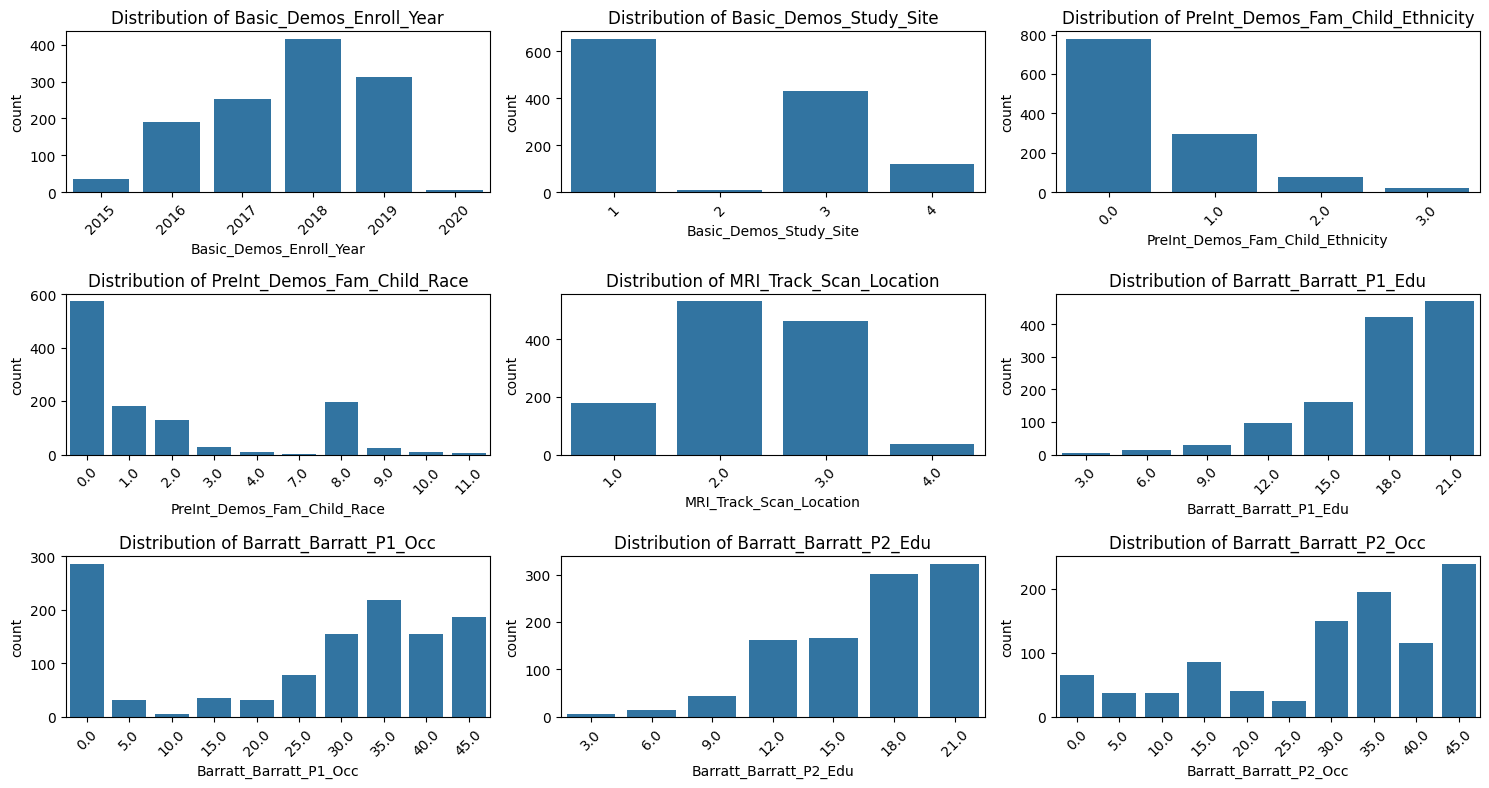

In [42]:
categorical_columns = train_c.select_dtypes(include='category').columns

# Create subplots to visualize each categorical variable's distribution
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns) // 3 + 1, 3, i)
    sns.countplot(data=train_c, x=column)
    plt.title(f"Distribution of {column}")
    plt.xticks(rotation=45)  # Rotate x labels if necessary

plt.tight_layout()
plt.show()

In [43]:
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
def cramers_v(cross_tab):
    chi2, p, dof, expected = stats.chi2_contingency(cross_tab)
    n = cross_tab.sum().sum()
    return np.sqrt(chi2 / (n * (min(cross_tab.shape) - 1)))
categorical_columns = train_c.select_dtypes(include='category').columns
train_c_encoded = train_c.copy()
for col in categorical_columns:
    train_c_encoded[col] = train_c_encoded[col].cat.codes  
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))), 
                                columns=categorical_columns, index=categorical_columns)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            cross_tab = pd.crosstab(train_c_encoded[col1], train_c_encoded[col2])
            cramers_v_matrix.loc[col1, col2] = cramers_v(cross_tab)
print("Cramér's V Correlation Matrix:")
print(cramers_v_matrix)

Cramér's V Correlation Matrix:
                                  Basic_Demos_Enroll_Year  \
Basic_Demos_Enroll_Year                          0.000000   
Basic_Demos_Study_Site                           0.419986   
PreInt_Demos_Fam_Child_Ethnicity                 0.180506   
PreInt_Demos_Fam_Child_Race                      0.157450   
MRI_Track_Scan_Location                          0.508932   
Barratt_Barratt_P1_Edu                           0.107895   
Barratt_Barratt_P1_Occ                           0.150770   
Barratt_Barratt_P2_Edu                           0.112625   
Barratt_Barratt_P2_Occ                           0.126323   

                                  Basic_Demos_Study_Site  \
Basic_Demos_Enroll_Year                         0.419986   
Basic_Demos_Study_Site                          0.000000   
PreInt_Demos_Fam_Child_Ethnicity                0.093321   
PreInt_Demos_Fam_Child_Race                     0.138047   
MRI_Track_Scan_Location                         0.483145  

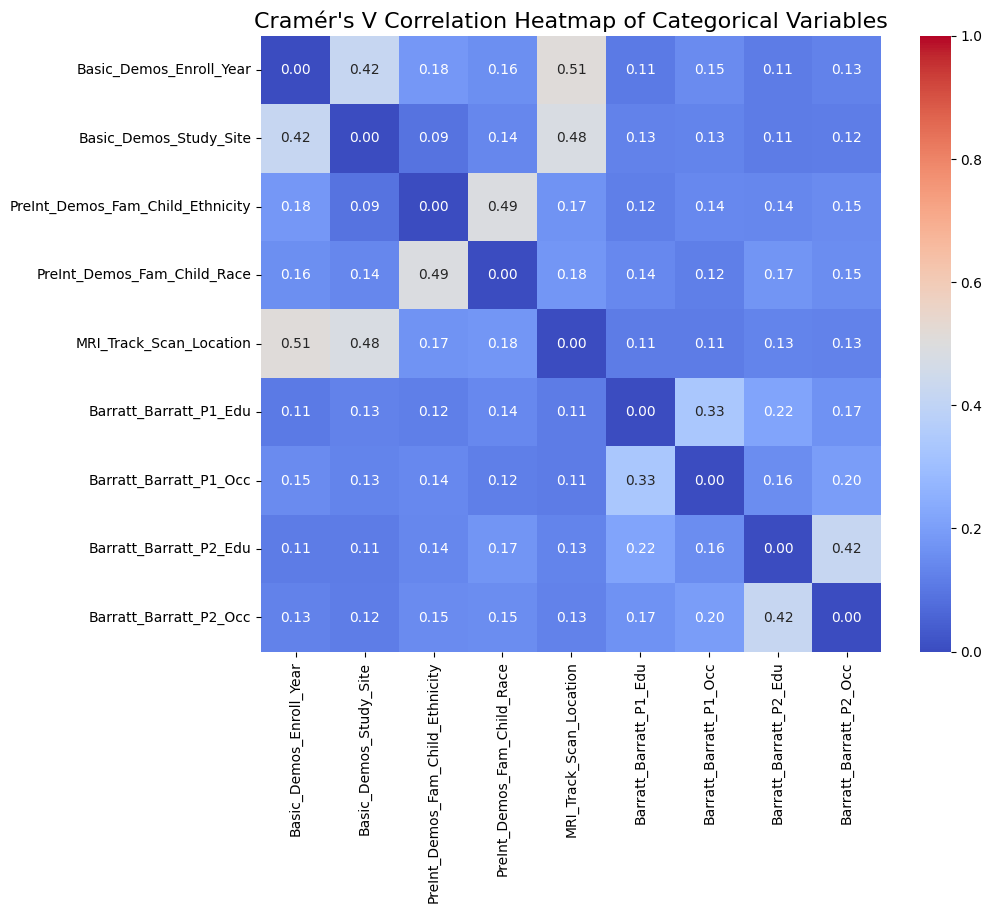

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Heatmap of Categorical Variables", fontsize=16)
plt.show()

In [47]:
features_adhd = [
    'APQ_P_APQ_P_CP',              # p = 0.0525 (borderline)
    'APQ_P_APQ_P_ID',              # p = 6.18e-05
    'APQ_P_APQ_P_INV',             # p = 0.00045
    'APQ_P_APQ_P_OPD',             # p = 7.01e-07
    'SDQ_SDQ_Emotional_Problems',  # p = 5.30e-14
    'SDQ_SDQ_Externalizing',       # p = 2.14e-72
    'SDQ_SDQ_Generating_Impact',   # p = 1.69e-47
    'SDQ_SDQ_Peer_Problems',       # p = 1.81e-15
    'SDQ_SDQ_Prosocial',           # p = 5.87e-12
    'Basic_Demos_Enroll_Year',     # p = 5.83e-09
    'Basic_Demos_Study_Site',      # p = 0.0145
    'MRI_Track_Scan_Location',     # p = 3.31e-07
]

features_sex = [
    'MRI_Track_Scan_Location',  # p-value: 0.0482 (significant)
    'Barratt_Barratt_P1_Edu',   # p-value: 0.126 (borderline significance)
    'Barratt_Barratt_P2_Edu',   # p-value: 0.110 (borderline significance)
    'SDQ_SDQ_Emotional_Problems',  # p-value: 0.0004 (highly significant)
    'SDQ_SDQ_Hyperactivity',      # p-value: 1.98e-06 (highly significant)
    'SDQ_SDQ_Prosocial',         # p-value: 1.7e-05 (highly significant)
    'APQ_P_APQ_P_INV',           # p-value: 0.0408 (significant)
    'APQ_P_APQ_P_OPD',           # p-value: 0.0149 (significant)
    'SDQ_SDQ_Conduct_Problems'  # p-value: 0.0428 (significant)
]

interactions = [
    'SDQ_SDQ_Difficulties_Total',
    'SDQ_SDQ_Generating_Impact',
    'Basic_Demos_Enroll_Year',
    'Basic_Demos_Study_Site',
    'MRI_Track_Scan_Location',
]

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

# Assuming categorical_columns is a list of column names
# Ensure categorical_columns refers to the DataFrame and labels is the binary outcome Series

for column in categorical_columns:
    # Create a contingency table using the DataFrame (assuming your main data is in 'data')
    contingency_table = pd.crosstab(train_combined[column], labels['ADHD_Outcome'])
    
    # Perform the Chi-square test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    # Print results
    print(f"Variable: {column} - Chi2 Stat: {chi2_stat}, p-value: {p_val}")

Variable: Basic_Demos_Enroll_Year - Chi2 Stat: 46.94471972972127, p-value: 5.830819392127769e-09
Variable: Basic_Demos_Study_Site - Chi2 Stat: 10.538325388025893, p-value: 0.014503155035049294
Variable: PreInt_Demos_Fam_Child_Ethnicity - Chi2 Stat: 0.5442846331711102, p-value: 0.9090599491752034
Variable: PreInt_Demos_Fam_Child_Race - Chi2 Stat: 9.110897657832957, p-value: 0.4271010327284097
Variable: MRI_Track_Scan_Location - Chi2 Stat: 32.94345463514867, p-value: 3.3103478110033836e-07
Variable: Barratt_Barratt_P1_Edu - Chi2 Stat: 2.3570812125654252, p-value: 0.8841071539349921
Variable: Barratt_Barratt_P1_Occ - Chi2 Stat: 5.700361781830659, p-value: 0.7694922479074343
Variable: Barratt_Barratt_P2_Edu - Chi2 Stat: 1.42184463555478, p-value: 0.9645161092527277
Variable: Barratt_Barratt_P2_Occ - Chi2 Stat: 3.4725464070505785, p-value: 0.9425883523700862


In [36]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

# Assuming categorical_columns is a list of column names
# Ensure categorical_columns refers to the DataFrame and labels is the binary outcome Series

for column in categorical_columns:
    # Create a contingency table using the DataFrame (assuming your main data is in 'data')
    contingency_table = pd.crosstab(train_combined[column], labels['Sex_F'])
    
    # Perform the Chi-square test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    # Print results
    print(f"Variable: {column} - Chi2 Stat: {chi2_stat}, p-value: {p_val}")


Variable: Basic_Demos_Enroll_Year - Chi2 Stat: 4.238601475441587, p-value: 0.5155993227535681
Variable: Basic_Demos_Study_Site - Chi2 Stat: 3.5929626109216093, p-value: 0.30890381833067
Variable: PreInt_Demos_Fam_Child_Ethnicity - Chi2 Stat: 0.773494752898515, p-value: 0.8557956606348922
Variable: PreInt_Demos_Fam_Child_Race - Chi2 Stat: 5.871931095847471, p-value: 0.7526644302969351
Variable: MRI_Track_Scan_Location - Chi2 Stat: 7.895466582435335, p-value: 0.04822222702966921
Variable: Barratt_Barratt_P1_Edu - Chi2 Stat: 9.96833412029051, p-value: 0.12599188801895914
Variable: Barratt_Barratt_P1_Occ - Chi2 Stat: 7.641168030161712, p-value: 0.5706723641278433
Variable: Barratt_Barratt_P2_Edu - Chi2 Stat: 10.37871841845677, p-value: 0.10958288558407019
Variable: Barratt_Barratt_P2_Occ - Chi2 Stat: 11.35830712532976, p-value: 0.2519459425457987


In [31]:
from scipy.stats import mannwhitneyu

# Loop through each quantitative column
for col in quantitative_columns:
    # Separate data for the two groups (ADHD_Outcome = 0 and ADHD_Outcome = 1)
    group_0 = train_combined[labels['ADHD_Outcome'] == 0][col].dropna()
    group_1 = train_combined[labels['ADHD_Outcome'] == 1][col].dropna()
    
    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(group_0, group_1)
    print(f"Variable: {col} - U-statistic: {stat}, p-value: {p_value}")



Variable: EHQ_EHQ_Total - U-statistic: 148710.5, p-value: 0.21603131803816045
Variable: ColorVision_CV_Score - U-statistic: 152959.0, p-value: 0.827562379621632
Variable: APQ_P_APQ_P_CP - U-statistic: 145674.0, p-value: 0.05252514970111672
Variable: APQ_P_APQ_P_ID - U-statistic: 132847.0, p-value: 6.179062000374195e-05
Variable: APQ_P_APQ_P_INV - U-statistic: 174623.0, p-value: 0.00044996421306963926
Variable: APQ_P_APQ_P_OPD - U-statistic: 127563.0, p-value: 7.010339716617715e-07
Variable: APQ_P_APQ_P_PM - U-statistic: 149579.0, p-value: 0.3206159884534413
Variable: APQ_P_APQ_P_PP - U-statistic: 157135.0, p-value: 0.713734957543757
Variable: SDQ_SDQ_Conduct_Problems - U-statistic: 101999.5, p-value: 9.234747585911899e-23
Variable: SDQ_SDQ_Difficulties_Total - U-statistic: 63618.5, p-value: 3.2332247704951674e-61
Variable: SDQ_SDQ_Emotional_Problems - U-statistic: 114432.0, p-value: 5.297212365184384e-14
Variable: SDQ_SDQ_Externalizing - U-statistic: 55451.5, p-value: 2.136125814848136

In [32]:
# Loop through each quantitative column
for col in quantitative_columns:
    # Separate data for the two groups (ADHD_Outcome = 0 and ADHD_Outcome = 1)
    group_0 = train_combined[labels['Sex_F'] == 0][col].dropna()
    group_1 = train_combined[labels['Sex_F'] == 1][col].dropna()
    
    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(group_0, group_1)
    print(f"Variable: {col} - U-statistic: {stat}, p-value: {p_value}")


Variable: EHQ_EHQ_Total - U-statistic: 167492.5, p-value: 0.34497305377141785
Variable: ColorVision_CV_Score - U-statistic: 155991.5, p-value: 0.3533615234234385
Variable: APQ_P_APQ_P_CP - U-statistic: 166309.0, p-value: 0.4033949885948186
Variable: APQ_P_APQ_P_ID - U-statistic: 167540.0, p-value: 0.34313456520586794
Variable: APQ_P_APQ_P_INV - U-statistic: 173795.0, p-value: 0.0407540670469921
Variable: APQ_P_APQ_P_OPD - U-statistic: 175971.0, p-value: 0.014920516034632443
Variable: APQ_P_APQ_P_PM - U-statistic: 161035.0, p-value: 0.843843949858393
Variable: APQ_P_APQ_P_PP - U-statistic: 173405.5, p-value: 0.04726807075363899
Variable: SDQ_SDQ_Conduct_Problems - U-statistic: 174526.0, p-value: 0.042777183656012706
Variable: SDQ_SDQ_Difficulties_Total - U-statistic: 173284.5, p-value: 0.0764178557964369
Variable: SDQ_SDQ_Emotional_Problems - U-statistic: 143363.0, p-value: 0.00044687292994360645
Variable: SDQ_SDQ_Externalizing - U-statistic: 186699.5, p-value: 3.726151701435882e-05
Var

In [5]:
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity",
    "PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
]
train_combined.drop(drop_cols, axis=1, inplace=True)
test_combined.drop(drop_cols, axis=1, inplace=True)

# Standardize features
scaler = StandardScaler()
train_combined = pd.DataFrame(
    scaler.fit_transform(train_combined), columns=train_combined.columns, index=train_combined.index
)
test_combined = pd.DataFrame(
    scaler.transform(test_combined), columns=test_combined.columns, index=test_combined.index
)

# Impute missing values using IterativeImputer with Lasso
imputer = IterativeImputer(estimator=LassoCV(random_state=SEED), max_iter=5, random_state=SEED)
train_combined[:] = imputer.fit_transform(train_combined)
test_combined[:] = imputer.transform(test_combined)

# Improved Imputation using Elastic Net
#imputer = IterativeImputer(
 #   estimator=ElasticNetCV(l1_ratio=0.5, random_state=SEED),  # Elastic Net (L1 + L2)
  #  max_iter=10,  # More iterations for stability
   # n_nearest_features=10,  # Use nearest features for better imputation
    #random_state=SEED)
#train_combined[:] = imputer.fit_transform(train_combined)
#test_combined[:] = imputer.transform(test_combined)

# Retrieve targets
y_adhd = labels["ADHD_Outcome"]
y_sex = labels["Sex_F"]
# ADHD&Sex Combinations to stratify on
combinations = labels["ADHD_Outcome"].astype(str) + labels["Sex_F"].astype(str)

In [6]:
features_sex = [
       'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'MRI_Track_Age_at_Scan',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu'
]

features_adhd = [
       'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu', 'sex_proba',
       'I_APQ_P_APQ_P_INV', 'I_APQ_P_APQ_P_PP', 'I_SDQ_SDQ_Hyperactivity',
       'I_MRI_Track_Age_at_Scan', 'I_SDQ_SDQ_Generating_Impact'
]

# Features to be interacted with predicted probability of Sex_F = 1
interactions = [
    "APQ_P_APQ_P_INV", "APQ_P_APQ_P_PP", "SDQ_SDQ_Hyperactivity", 
    "MRI_Track_Age_at_Scan", "SDQ_SDQ_Generating_Impact"
]

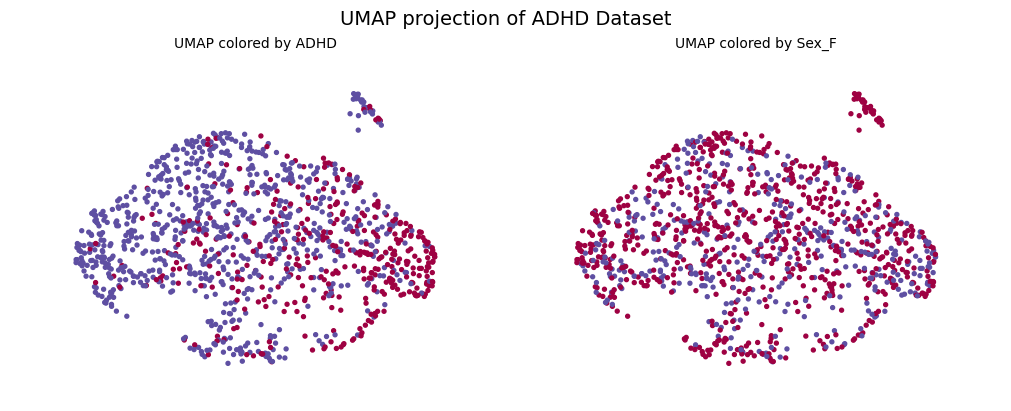

In [7]:
# Setup
pipe = make_pipeline(SimpleImputer(), MinMaxScaler())
reducer = umap.UMAP(random_state=SEED)

# Select features to visualize
available_features = [f for f in features_adhd if f in train_combined.columns]
x_scaler = pipe.fit_transform(train_combined[available_features])
 # or use features_sex if you prefer

# Fit UMAP
embedding = reducer.fit_transform(x_scaler)

# Plotting
_, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

targets = {"ADHD": y_adhd, "Sex_F": y_sex}
for t, ax in zip(targets, axs.ravel()):
    sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=targets[t], cmap='Spectral', s=8)
    ax.set_title(f'UMAP colored by {t}', fontsize=10)
    ax.set_aspect('equal', 'datalim')
    ax.axis('off')

plt.suptitle('UMAP projection of ADHD Dataset', fontsize=14)
plt.show()


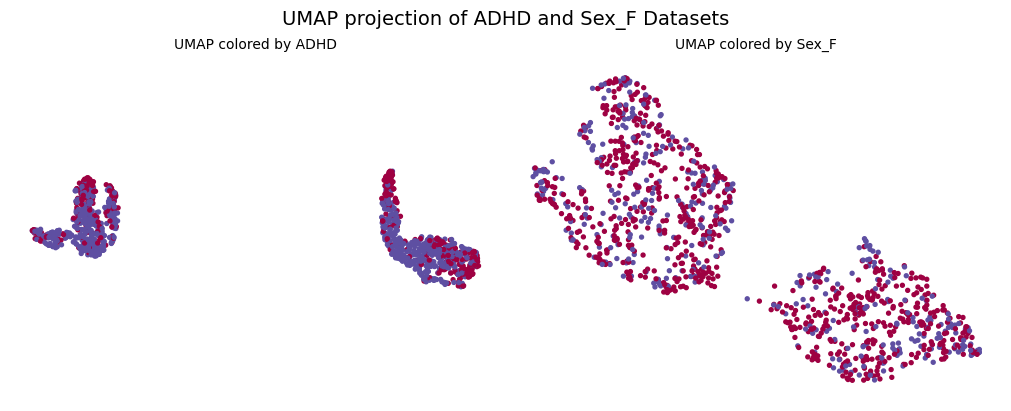

In [50]:
# Setup
pipe = make_pipeline(SimpleImputer(), MinMaxScaler())
reducer = umap.UMAP(random_state=SEED)

# Select features to visualize for ADHD and Sex_F
# Ensure to use specific features for each target (ADHD or Sex_F)
available_features_adhd = [f for f in features_adhd if f in train_combined.columns]
available_features_sex = [f for f in features_sex if f in train_combined.columns]

# Fit UMAP for ADHD features
x_scaler_adhd = pipe.fit_transform(train_combined[available_features_adhd])

# Fit UMAP for Sex_F features
x_scaler_sex = pipe.fit_transform(train_combined[available_features_sex])

# Fit UMAP for both
embedding_adhd = reducer.fit_transform(x_scaler_adhd)
embedding_sex = reducer.fit_transform(x_scaler_sex)

# Plotting
_, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Target for ADHD
ax = axs[0]
sc_adhd = ax.scatter(embedding_adhd[:, 0], embedding_adhd[:, 1], c=y_adhd, cmap='Spectral', s=8)
ax.set_title(f'UMAP colored by ADHD', fontsize=10)
ax.set_aspect('equal', 'datalim')
ax.axis('off')

# Target for Sex_F
ax = axs[1]
sc_sex = ax.scatter(embedding_sex[:, 0], embedding_sex[:, 1], c=y_sex, cmap='Spectral', s=8)
ax.set_title(f'UMAP colored by Sex_F', fontsize=10)
ax.set_aspect('equal', 'datalim')
ax.axis('off')

plt.suptitle('UMAP projection of ADHD and Sex_F Datasets', fontsize=14)
plt.show()


In [53]:
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    """Evaluate predictions using Brier Score and F1 Score."""
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    return brier, f1

# store oof brier and f1
scores_sex = []
scores_adhd = []

# store oof predictions for diagnostics and threshold optimization
sex_oof = np.zeros(len(y_sex))
adhd_oof = np.zeros(len(y_adhd))

# classification thresholds
t_sex = 0.3
t_adhd = 0.4

# Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)

skf = StratifiedKFold(n_splits=FOLDS)

params_1 = {
    "penalty": "elasticnet",           # Elastic Net regularization
    "Cs": 10,                           # Number of Cs (inverse of regularization strength) to try
    "cv": skf,                          # Stratified K-Folds cross-validator
    "fit_intercept": True,             # Whether to add intercept
    "scoring": "f1",                   # Scoring metric
    "random_state": SEED,              # Reproducibility
    "solver": "saga",                  # saga supports elasticnet
    "l1_ratios": [0.1, 0.5, 0.9]       # List of l1_ratios to try in the cross-validation
}

params_2 = {
    "penalty":"l1", 
    "Cs": 10, 
    "cv":skf, 
    "fit_intercept":True, 
    "scoring": "f1", 
    "random_state": SEED, 
    "solver": "saga"
}

model_1 = LogisticRegressionCV(**params_1)
model_2 = LogisticRegressionCV(**params_2)

for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_val = train_combined.iloc[train_idx], train_combined.iloc[val_idx]
    y_train_adhd, y_val_adhd = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
    y_train_sex, y_val_sex = y_sex.iloc[train_idx], y_sex.iloc[val_idx]
    # 2x weight for Sex_F == 1 and ADHD_Outcome == 1 (as mentioned in competition evaluation)
    weights_train = np.where(combinations.iloc[train_idx]=="11", 2, 1)
    weights = np.where(combinations.iloc[val_idx]=="11", 2, 1)

    # ----------------
    # Sex_F prediction
    # ----------------
    # Model 1
    model_1.fit(X_train[features_sex], y_train_sex, sample_weight=weights_train)
    sex_train = model_1.predict_proba(X_train[features_sex])[:, 1]
    sex_val = model_1.predict_proba(X_val[features_sex])[:, 1]
    sex_oof[val_idx] += sex_val / REPEATS

    sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val, weights, "Sex_F", thresh=t_sex)
    scores_sex.append((sex_brier, sex_f1))

    # ----------------
    # Outcome_ADHD prediction
    # ----------------
    # Add predicted proba from previous model
    X_train["sex_proba"] = sex_train
    X_val["sex_proba"] = sex_val

    # adding interactions between predicted sex and other features
    for interaction in interactions:
        X_train[f"I_{interaction}"] = X_train[interaction] * X_train["sex_proba"]
        X_val[f"I_{interaction}"] = X_val[interaction] * X_val["sex_proba"]

    # Logistic Regression with L1 penalty
    model_2.fit(X_train[features_adhd], y_train_adhd, sample_weight=weights_train)
    
    adhd_val = model_2.predict_proba(X_val[features_adhd])[:, 1]
    adhd_oof[val_idx] += adhd_val / REPEATS
    adhd_brier, adhd_f1 = eval_metrics(y_val_adhd, adhd_val, weights, "Outcome ADHD", thresh=t_adhd)
    scores_adhd.append((adhd_brier, adhd_f1))

print(f"\n=== CV Results ===")
print(f"Sex Mean Brier Score: {np.mean([s[0] for s in scores_sex]):.4f}")
print(f"Sex Mean F1: {np.mean([s[1] for s in scores_sex]):.4f}")
print(f"ADHD Mean Brier Score: {np.mean([s[0] for s in scores_adhd]):.4f}")
print(f"ADHD Mean F1: {np.mean([s[1] for s in scores_adhd]):.4f}")


=== Fold 1 ===
Sex_F -> Brier Score: 0.2232, F1: 0.6070
Outcome ADHD -> Brier Score: 0.1636, F1: 0.8719

=== Fold 2 ===
Sex_F -> Brier Score: 0.2286, F1: 0.6203
Outcome ADHD -> Brier Score: 0.1548, F1: 0.8739

=== Fold 3 ===
Sex_F -> Brier Score: 0.2193, F1: 0.6468
Outcome ADHD -> Brier Score: 0.1412, F1: 0.8773

=== Fold 4 ===
Sex_F -> Brier Score: 0.2300, F1: 0.6221
Outcome ADHD -> Brier Score: 0.1393, F1: 0.8935

=== Fold 5 ===
Sex_F -> Brier Score: 0.2285, F1: 0.6357
Outcome ADHD -> Brier Score: 0.1407, F1: 0.8922

=== Fold 6 ===
Sex_F -> Brier Score: 0.2248, F1: 0.6368
Outcome ADHD -> Brier Score: 0.1452, F1: 0.8981

=== Fold 7 ===
Sex_F -> Brier Score: 0.2353, F1: 0.6237
Outcome ADHD -> Brier Score: 0.1347, F1: 0.8935

=== Fold 8 ===
Sex_F -> Brier Score: 0.2306, F1: 0.5895
Outcome ADHD -> Brier Score: 0.1414, F1: 0.8932

=== Fold 9 ===
Sex_F -> Brier Score: 0.2214, F1: 0.6357
Outcome ADHD -> Brier Score: 0.1496, F1: 0.8847

=== Fold 10 ===
Sex_F -> Brier Score: 0.2166, F1: 0.62

In [9]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models.tab_fpn import TabFPNModelConfig
from pytorch_tabular.config import DataConfig, TrainerConfig
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import brier_score_loss, f1_score
import torch

def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    return brier, f1

# Scores + OOFs
scores_sex = []
scores_adhd = []
sex_oof = np.zeros(len(y_sex))
adhd_oof = np.zeros(len(y_adhd))

# CV setup
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
    print(f"\n=== Fold {fold} ===")

    # --- Split ---
    X_train, X_val = train_combined.iloc[train_idx].copy(), train_combined.iloc[val_idx].copy()
    y_train_sex, y_val_sex = y_sex.iloc[train_idx], y_sex.iloc[val_idx]
    y_train_adhd, y_val_adhd = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
    weights_train = np.where(combinations.iloc[train_idx] == "11", 2, 1)
    weights = np.where(combinations.iloc[val_idx] == "11", 2, 1)

    # Prepare data for pytorch-tabular
    df_sex_train = X_train[features_sex].copy()
    df_sex_train["Sex_F"] = y_train_sex.values
    df_sex_val = X_val[features_sex].copy()
    df_sex_val["Sex_F"] = y_val_sex.values

    # --- TabFPN for Sex_F ---
    data_config = DataConfig(
        target=["Sex_F"],
        continuous_cols=features_sex,
    )
    model_config = TabFPNModelConfig(
        task="classification",
        layers="64-32",
        activation="relu",
        dropout=0.1
    )
    trainer_config = TrainerConfig(
        max_epochs=50,
        batch_size=256,
        auto_lr_find=True,
        gpus=1 if torch.cuda.is_available() else 0,
    )
    tabular_model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        trainer_config=trainer_config,
    )

    tabular_model.fit(train=df_sex_train, validation=df_sex_val)

    # Predict proba
    sex_val_pred = tabular_model.predict(df_sex_val)["prediction_probability"].values
    sex_train_pred = tabular_model.predict(df_sex_train)["prediction_probability"].values

    sex_oof[val_idx] += sex_val_pred.flatten() / REPEATS
    sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val_pred, weights, "Sex_F", thresh=t_sex)
    scores_sex.append((sex_brier, sex_f1))

    # Add sex prediction + interactions to ADHD feature set
    X_train["sex_proba"] = sex_train_pred
    X_val["sex_proba"] = sex_val_pred

    for interaction in interactions:
        X_train[f"I_{interaction}"] = X_train[interaction] * X_train["sex_proba"]
        X_val[f"I_{interaction}"] = X_val[interaction] * X_val["sex_proba"]

    df_adhd_train = X_train[features_adhd].copy()
    df_adhd_train["ADHD_Outcome"] = y_train_adhd.values
    df_adhd_val = X_val[features_adhd].copy()
    df_adhd_val["ADHD_Outcome"] = y_val_adhd.values

    # --- TabFPN for ADHD ---
    data_config = DataConfig(
        target=["ADHD_Outcome"],
        continuous_cols=features_adhd,
    )
    model_config = TabFPNModelConfig(
        task="classification",
        layers="64-32",
        activation="relu",
        dropout=0.1
    )
    trainer_config = TrainerConfig(
        max_epochs=50,
        batch_size=256,
        auto_lr_find=True,
        gpus=1 if torch.cuda.is_available() else 0,
    )
    tabular_model_adhd = TabularModel(
        data_config=data_config,
        model_config=model_config,
        trainer_config=trainer_config,
    )

    tabular_model_adhd.fit(train=df_adhd_train, validation=df_adhd_val)

    adhd_val_pred = tabular_model_adhd.predict(df_adhd_val)["prediction_probability"].values
    adhd_oof[val_idx] += adhd_val_pred.flatten() / REPEATS

    adhd_brier, adhd_f1 = eval_metrics(y_val_adhd, adhd_val_pred, weights, "Outcome ADHD", thresh=t_adhd)
    scores_adhd.append((adhd_brier, adhd_f1))

# --- Final Scores ---
print(f"\n=== CV Results ===")
print(f"Sex Mean Brier Score: {np.mean([s[0] for s in scores_sex]):.4f}")
print(f"Sex Mean F1: {np.mean([s[1] for s in scores_sex]):.4f}")
print(f"ADHD Mean Brier Score: {np.mean([s[0] for s in scores_adhd]):.4f}")
print(f"ADHD Mean F1: {np.mean([s[1] for s in scores_adhd]):.4f}")


ImportError: cannot import name '_cuda' from 'torch._utils' (/projectnb/msspbc/vajinder/myenv/lib/python3.10/site-packages/torch/_utils.py)

In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import brier_score_loss, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
import numpy as np

# Function to evaluate metrics: Brier Score and F1 Score
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    """Evaluate predictions using Brier Score and F1 Score."""
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    return brier, f1

# store oof brier and f1
scores_sex = []
scores_adhd = []

# store oof predictions for diagnostics and threshold optimization
sex_oof = np.zeros(len(y_sex))
adhd_oof = np.zeros(len(y_adhd))

# classification thresholds
t_sex = 0.3
t_adhd = 0.4

# Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)

skf = StratifiedKFold(n_splits=FOLDS)

# MLP Classifier parameters for model_1 (Sex_F prediction)
params_1_mlp = {
    "hidden_layer_sizes": (100,),         # Number of neurons in the hidden layer (adjust this as needed)
    "activation": "relu",                 # Activation function for the hidden layer (ReLU is common)
    "solver": "adam",                     # Optimization algorithm (adam is efficient)
    "max_iter": 500,                      # Maximum number of iterations (adjust as needed)
    "random_state": SEED,                 # Reproducibility
    "learning_rate": "adaptive",          # Adaptive learning rate
    "early_stopping": True,               # Stop training when validation score is not improving
}

# Initialize the MLP model for Sex_F prediction
model_1_mlp = MLPClassifier(**params_1_mlp)

# Logistic Regression with L1 penalty for Outcome_ADHD prediction
params_2 = {
    "penalty":"l1", 
    "Cs": 10, 
    "cv":skf, 
    "fit_intercept":True, 
    "scoring": "f1", 
    "random_state": SEED, 
    "solver": "saga"
}

model_2 = LogisticRegressionCV(**params_2)

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_val = train_combined.iloc[train_idx], train_combined.iloc[val_idx]
    y_train_adhd, y_val_adhd = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
    y_train_sex, y_val_sex = y_sex.iloc[train_idx], y_sex.iloc[val_idx]

    # 2x weight for Sex_F == 1 and ADHD_Outcome == 1 (as mentioned in competition evaluation)
    weights_train = np.where(combinations.iloc[train_idx] == "11", 2, 1)
    weights = np.where(combinations.iloc[val_idx] == "11", 2, 1)

    # ----------------
    # Sex_F prediction using MLP Classifier
    # ----------------
    weights_train = np.array(weights_train)
    model_1_mlp.fit(X_train[features_sex], y_train_sex)
    sex_train = model_1_mlp.predict_proba(X_train[features_sex])[:, 1]
    sex_val = model_1_mlp.predict_proba(X_val[features_sex])[:, 1]
    sex_oof[val_idx] += sex_val / REPEATS

    sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val, weights, "Sex_F", thresh=t_sex)
    scores_sex.append((sex_brier, sex_f1))

    # ----------------
    # Outcome_ADHD prediction
    # ----------------
    # Add predicted proba from previous model
    X_train["sex_proba"] = sex_train
    X_val["sex_proba"] = sex_val

    # Adding interactions between predicted sex and other features
    for interaction in interactions:
        X_train[f"I_{interaction}"] = X_train[interaction] * X_train["sex_proba"]
        X_val[f"I_{interaction}"] = X_val[interaction] * X_val["sex_proba"]

    # Logistic Regression with L1 penalty for ADHD prediction
    model_2.fit(X_train[features_adhd], y_train_adhd, sample_weight=weights_train)
    
    adhd_val = model_2.predict_proba(X_val[features_adhd])[:, 1]
    adhd_oof[val_idx] += adhd_val / REPEATS
    adhd_brier, adhd_f1 = eval_metrics(y_val_adhd, adhd_val, weights, "Outcome ADHD", thresh=t_adhd)
    scores_adhd.append((adhd_brier, adhd_f1))

# After the loop ends, print the average metrics
print(f"\n=== CV Results ===")
print(f"Sex Mean Brier Score: {np.mean([s[0] for s in scores_sex]):.4f}")
print(f"Sex Mean F1: {np.mean([s[1] for s in scores_sex]):.4f}")
print(f"ADHD Mean Brier Score: {np.mean([s[0] for s in scores_adhd]):.4f}")
print(f"ADHD Mean F1: {np.mean([s[1] for s in scores_adhd]):.4f}")



=== Fold 1 ===
Sex_F -> Brier Score: 0.2263, F1: 0.5825
Outcome ADHD -> Brier Score: 0.1636, F1: 0.8719

=== Fold 2 ===
Sex_F -> Brier Score: 0.2211, F1: 0.5515
Outcome ADHD -> Brier Score: 0.1548, F1: 0.8739

=== Fold 3 ===
Sex_F -> Brier Score: 0.2247, F1: 0.6205
Outcome ADHD -> Brier Score: 0.1412, F1: 0.8773

=== Fold 4 ===
Sex_F -> Brier Score: 0.2242, F1: 0.5366
Outcome ADHD -> Brier Score: 0.1393, F1: 0.8935

=== Fold 5 ===
Sex_F -> Brier Score: 0.2130, F1: 0.6325
Outcome ADHD -> Brier Score: 0.1407, F1: 0.8922

=== Fold 6 ===
Sex_F -> Brier Score: 0.2135, F1: 0.5928
Outcome ADHD -> Brier Score: 0.1452, F1: 0.8981

=== Fold 7 ===
Sex_F -> Brier Score: 0.2308, F1: 0.5590
Outcome ADHD -> Brier Score: 0.1347, F1: 0.8935

=== Fold 8 ===
Sex_F -> Brier Score: 0.2232, F1: 0.5300
Outcome ADHD -> Brier Score: 0.1414, F1: 0.8932

=== Fold 9 ===
Sex_F -> Brier Score: 0.2296, F1: 0.6225
Outcome ADHD -> Brier Score: 0.1496, F1: 0.8847

=== Fold 10 ===
Sex_F -> Brier Score: 0.2073, F1: 0.61

In [24]:
print(f"Shape of weights_train: {weights_train.shape}")
print(f"Shape of y_train_sex: {y_train_sex.shape}")


Shape of weights_train: (970,)
Shape of y_train_sex: (970,)


In [54]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.pyplot as plt

def plot_calibration(y_true, y_pred, name="Model", n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins, strategy='uniform')

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label=name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("True Probability")
    plt.title(f"Calibration Curve - {name}")
    plt.legend()
    plt.grid()
    plt.show()


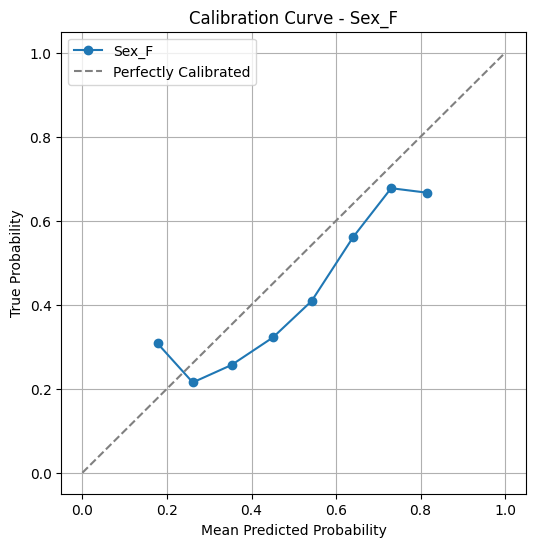

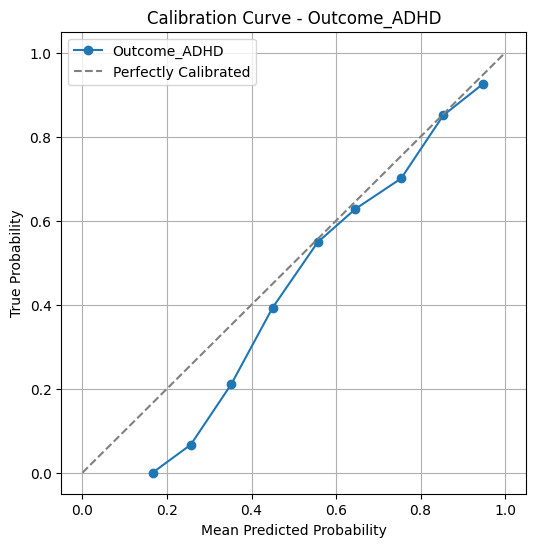

In [55]:
plot_calibration(y_sex, sex_oof, name="Sex_F")
plot_calibration(y_adhd, adhd_oof, name="Outcome_ADHD")


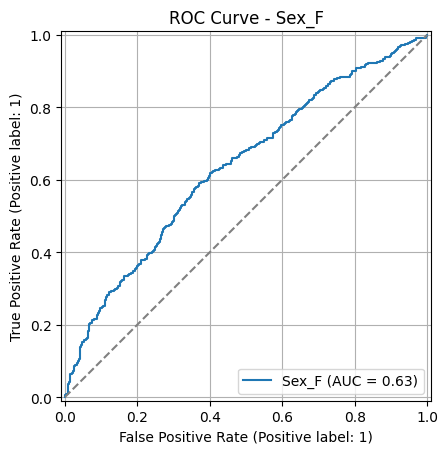

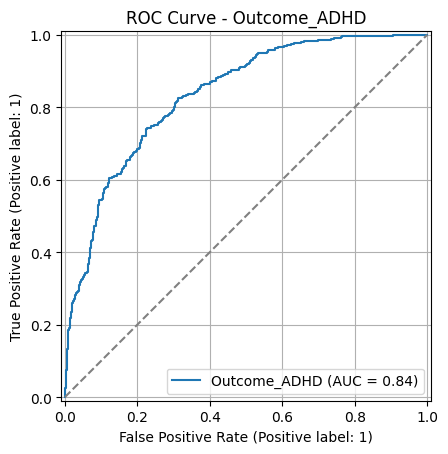

In [56]:
from sklearn.metrics import RocCurveDisplay

def plot_roc(y_true, y_pred, label):
    RocCurveDisplay.from_predictions(y_true, y_pred, name=label)
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.grid()
    plt.title(f"ROC Curve - {label}")
    plt.show()

plot_roc(y_sex, sex_oof, "Sex_F")
plot_roc(y_adhd, adhd_oof, "Outcome_ADHD")

In [57]:
weights = ((y_adhd == 1) & (y_sex == 1)) + 1
# Compute F1 scores and find the best threshold for sex_oof
thresholds = np.linspace(0, 1, 100)
sex_scores = []
for t in tqdm(thresholds, desc="Sex Thresholds"):
    tmp_pred = np.where(sex_oof > t, 1, 0)
    tmp_score = f1_score(y_sex, tmp_pred, sample_weight=weights)
    sex_scores.append(tmp_score)
best_sex_threshold = thresholds[np.argmax(sex_scores)]
best_sex_score = max(sex_scores)

# Compute F1 scores and find the best threshold for adhd_oof
adhd_scores = []
for t in tqdm(thresholds, desc="ADHD Thresholds"):
    tmp_pred = np.where(adhd_oof > t, 1, 0)
    tmp_score = f1_score(y_adhd, tmp_pred, sample_weight=weights)
    adhd_scores.append(tmp_score)
best_adhd_threshold = thresholds[np.argmax(adhd_scores)]
best_adhd_score = max(adhd_scores)


ADHD Thresholds: 100%|██████████| 100/100 [00:00<00:00, 518.52it/s]


In [58]:
model_1.fit(train_combined[features_sex], y_sex, sample_weight=weights)

sex_proba_train = model_1.predict_proba(train_combined[features_sex])[:,1]
sex_proba_test = model_1.predict_proba(test_combined[features_sex])[:,1]
coeffs_1 = pd.DataFrame({"feature": features_sex, "coeff": model_1.coef_[0]})
coeffs_1_sorted = coeffs_1.sort_values(by="coeff", key=abs, ascending=False)[:15]  # Top 15 important features
print(coeffs_1_sorted)
train_combined["sex_proba"] = sex_proba_train
test_combined["sex_proba"] = sex_proba_test

for interaction in interactions:
    train_combined[f"I_{interaction}"] = train_combined["sex_proba"] * train_combined[interaction]
    test_combined[f"I_{interaction}"] = test_combined["sex_proba"] * test_combined[interaction]

model_2.fit(train_combined[features_adhd], y_adhd, sample_weight=weights)

adhd_proba_test = model_2.predict_proba(test_combined[features_adhd])[:,1]
# Show most important features for model 2 
coeffs_2 = pd.DataFrame({"feature": features_adhd, "coeff": model_2.coef_[0]})
coeffs_2.sort_values(by="coeff", key=abs, ascending=False)[:15]

                      feature     coeff
3  SDQ_SDQ_Emotional_Problems  0.375142
5           SDQ_SDQ_Prosocial  0.268473
6             APQ_P_APQ_P_INV -0.215702
4       SDQ_SDQ_Hyperactivity -0.201749
1      Barratt_Barratt_P1_Edu  0.130969
7             APQ_P_APQ_P_OPD -0.093099
0     MRI_Track_Scan_Location -0.069187
2      Barratt_Barratt_P2_Edu -0.046620
8    SDQ_SDQ_Conduct_Problems  0.039946


,feature,coeff
5,SDQ_SDQ_Externalizing,1.172493
6,SDQ_SDQ_Generating_Impact,0.337501
9,Basic_Demos_Enroll_Year,0.309941
11,MRI_Track_Scan_Location,0.056733
0,APQ_P_APQ_P_CP,-0.010627
3,APQ_P_APQ_P_OPD,0.000000
1,APQ_P_APQ_P_ID,0.000000
2,APQ_P_APQ_P_INV,0.000000
7,SDQ_SDQ_Peer_Problems,0.000000
4,SDQ_SDQ_Emotional_Problems,0.000000


In [59]:
submission = pd.read_excel("/projectnb/msspbc/vajinder/WiDS/Data/SAMPLE_SUBMISSION.xlsx")
submission["ADHD_Outcome"] = np.where(adhd_proba_test > best_adhd_threshold, 1, 0)
submission["Sex_F"] = np.where(sex_proba_test > best_sex_threshold, 1, 0)
# Compare share of predicted labels at thresholds between OOF and Test
print(f"Share ADHD OOF: {np.mean(np.where(adhd_oof > best_adhd_threshold, 1, 0)):.4f} - Share ADHD Test: {submission.ADHD_Outcome.mean():.4f}")
print(f"Share Sex_F OOF: {np.mean(np.where(sex_oof > best_sex_threshold, 1, 0)):.4f} - Share Sex_F Test: {submission.Sex_F.mean():.4f}")

Share ADHD OOF: 0.8318 - Share ADHD Test: 1.0000
Share Sex_F OOF: 0.9431 - Share Sex_F Test: 0.9474


In [60]:
submission.to_csv("submission.csv", index=False)